In [2]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data
import matplotlib.pyplot as plt
import torch_geometric
import torch.nn as nn
import networkx as nx
import seaborn as sns
import pandas as pd
import numpy as np 
import torch
import os

In [3]:
data_path = './assets/ready/2017'
df = pd.read_csv(os.path.join(data_path, 'final.csv'))
df.columns = [col.strip() for col in df.columns.tolist()]

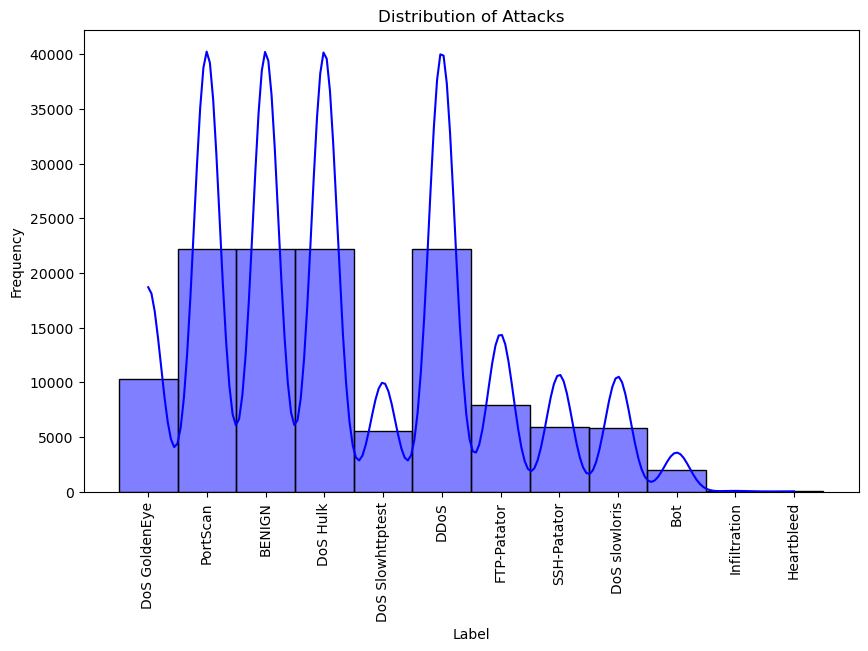

In [ ]:
label_column = 'Label'

plt.figure(figsize=(10, 6))
sns.histplot(df[label_column], kde=True, color='blue')
plt.title(f'Distribution of Attacks')
plt.xlabel(label_column)
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

In [19]:
class Preprocess:
    def __init__(self, df):
        self.df = df
        self.label_encoder = LabelEncoder()
    
    def preprocess(self):
        self.df['Label'] = self.df['Label'].map(lambda x: 0 if x == 'BENIGN' else 1)
        
        numerical_cols = self.df.select_dtypes(include=['number']).columns
        self.df[numerical_cols] = self.df[numerical_cols].replace([np.inf, -np.inf], np.nan)
        self.df[numerical_cols] = self.df[numerical_cols].fillna(self.df[numerical_cols].mean())
        
        cat_cols = self.df.select_dtypes(include=['object']).columns
        for col in cat_cols:
            self.df[col].fillna('unknown', inplace=True)
            self.df[col] = self.label_encoder.fit_transform(self.df[col].astype(str))
        
        return self.df

def create_graph_data(df):
    hosts = list(set(df['Source IP'].unique()) | set(df['Destination IP'].unique()))
    flows = list(df['Flow ID'].unique())
    
    host_mapping = {host: i for i, host in enumerate(hosts)}
    flow_mapping = {flow: i + len(hosts) for i, flow in enumerate(flows)}
    
    host_features = []
    flow_features = []
    
    for host in hosts:
        host_data = df[(df['Source IP'] == host) | (df['Destination IP'] == host)]
        host_features.append([
            host_data['Total Fwd Packets'].mean(),
            host_data['Total Backward Packets'].mean(),
            host_data['Total Length of Fwd Packets'].mean(),
            host_data['Flow Duration'].mean()
        ])
    
    for flow in flows:
        flow_data = df[df['Flow ID'] == flow]
        flow_features.append([
            flow_data['Flow Bytes/s'].mean(),
            flow_data['Flow Packets/s'].mean(),
            flow_data['Flow Duration'].mean(),
            flow_data['Total Fwd Packets'].mean()
        ])
    
    combined_features = host_features + flow_features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(combined_features)
    
    node_features = torch.tensor(scaled_features, dtype=torch.float)
    
    edges = []
    for _, row in df.iterrows():
        src = host_mapping[row['Source IP']]
        dst_flow = flow_mapping[row['Flow ID']]
        dst_host = host_mapping[row['Destination IP']]
        edges.append([src, dst_flow])
        edges.append([dst_flow, dst_host])
    
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    
    labels = torch.zeros(len(hosts) + len(flows), dtype=torch.long)
    flow_labels = df.groupby('Flow ID')['Label'].first()
    for flow, label in flow_labels.items():
        labels[flow_mapping[flow]] = label
    
    return Data(x=node_features, edge_index=edge_index, y=labels)


class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.conv1 = torch_geometric.nn.GATConv(input_dim, hidden_dim)
        self.conv2 = torch_geometric.nn.GATConv(hidden_dim, output_dim)
        self.classifier = nn.Linear(output_dim, 12)
        nn.init.xavier_uniform_(self.classifier.weight)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return self.classifier(x)


In [12]:
preprocessor = Preprocess(df)
df_processed = preprocessor.preprocess()

/tmp/ipykernel_3865/3145668928.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.df[col].fillna('unknown', inplace=True)
/tmp/ipykernel_3865/3145668928.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

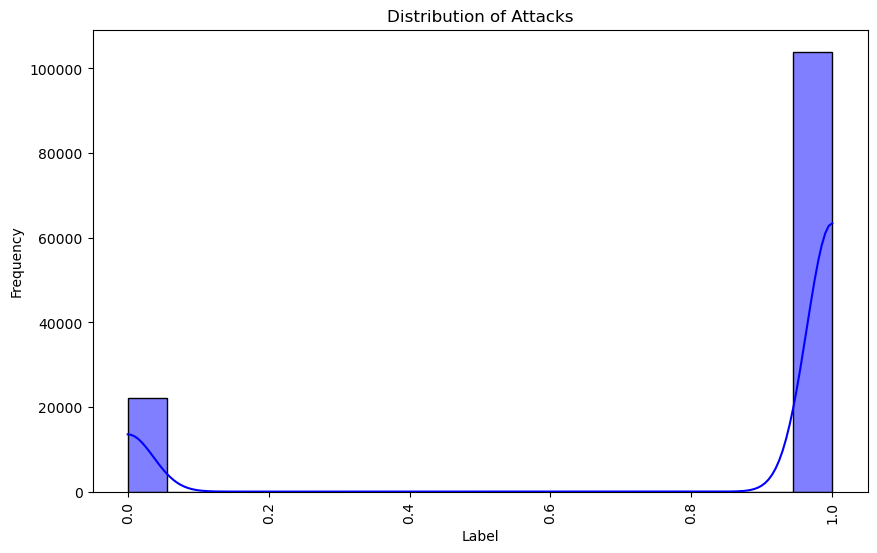

In [13]:
label_column = 'Label'

plt.figure(figsize=(10, 6))
sns.histplot(df_processed[label_column], kde=True, color='blue')
plt.title(f'Distribution of Attacks')
plt.xlabel(label_column)
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

In [14]:

graph_data = create_graph_data(df_processed)

train_mask = torch.zeros(graph_data.x.shape[0], dtype=torch.bool)
test_mask = torch.zeros(graph_data.x.shape[0], dtype=torch.bool)
train_indices, test_indices = train_test_split(range(graph_data.x.shape[0]), test_size=0.2)
train_mask[train_indices] = True
test_mask[test_indices] = True

graph_data.train_mask = train_mask
graph_data.test_mask = test_mask

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(input_dim=4, hidden_dim=64, output_dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()


In [ ]:
num_epochs = 500

history = {
    'loss': [],
    'val_loss': [],
    'accuracy': [],
    'val_accuracy': []
}

for epoch in range(num_epochs):
    x = graph_data.x.to(device)
    edge_index = graph_data.edge_index.to(device)
    y = graph_data.y.to(device)
    train_mask = graph_data.train_mask.to(device)
    
    
    
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    
    optimizer.zero_grad()
    out = model(x, edge_index)
    loss = criterion(out[train_mask], y[train_mask])
    
    train_loss += loss.item()
    _, predicted = torch.max(out[train_mask].data, 1)
    train_total += y[train_mask].size(0)
    train_correct += (predicted == y[train_mask]).sum().item()
    
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
    optimizer.step()
    
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        out = model(x, edge_index)
        val_loss = criterion(out[test_mask], y[test_mask]).item()
        _, predicted = torch.max(out[test_mask].data, 1)
        val_total += y[test_mask].size(0)
        val_correct += (predicted == y[test_mask]).sum().item()
    
    history['loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['accuracy'].append(train_correct / train_total)
    history['val_accuracy'].append(val_correct / val_total)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_correct/train_total:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_correct/val_total:.4f}')

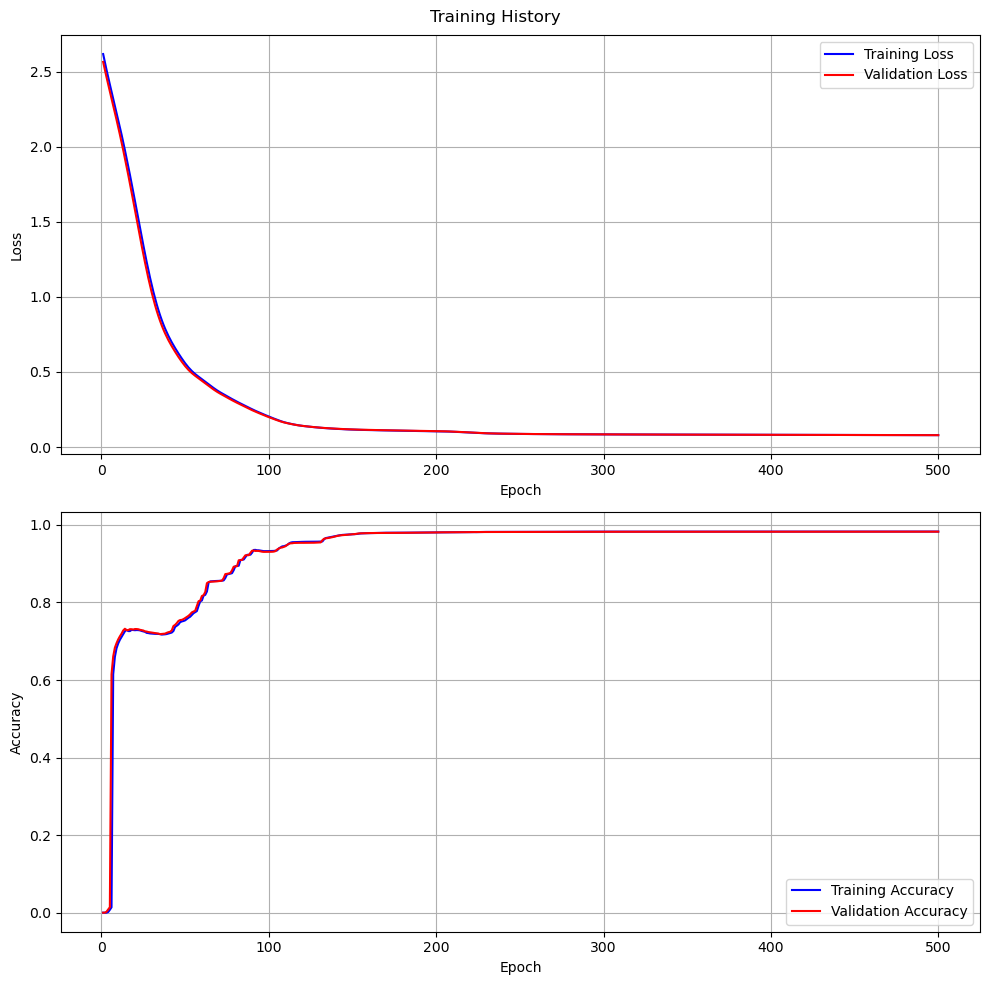

In [16]:


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
fig.suptitle('Training History')

epochs = range(1, len(history['loss']) + 1)
ax1.plot(epochs, history['loss'], 'b-', label='Training Loss')
ax1.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(epochs, history['accuracy'], 'b-', label='Training Accuracy')
ax2.plot(epochs, history['val_accuracy'], 'r-', label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:

model.eval()

x = graph_data.x.to(device)
edge_index = graph_data.edge_index.to(device)
y = graph_data.y.to(device)

test_mask = graph_data.test_mask.to(device)

with torch.no_grad():
    out = model(x, edge_index)
    preds = out.argmax(dim=1)  

y_true = y[test_mask].cpu().numpy()
y_pred = preds[test_mask].cpu().numpy()

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="binary") 
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1-score: {f1:.4f}")


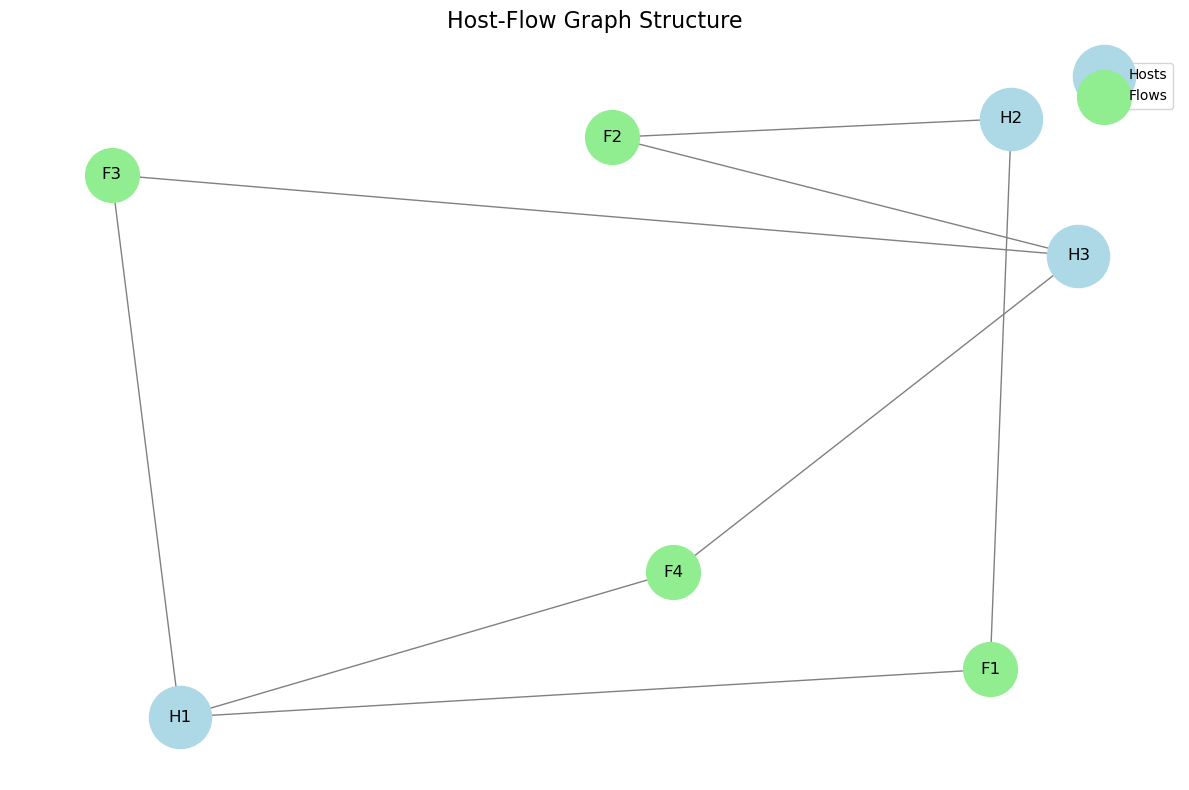

In [18]:

G = nx.DiGraph()

hosts = ['H1', 'H2', 'H3']
flows = ['F1', 'F2', 'F3', 'F4'] 

for host in hosts:
    G.add_node(host, node_type='host')
for flow in flows:
    G.add_node(flow, node_type='flow')

edges = [
    ('H1', 'F1'), ('F1', 'H2'),  # Flow 1: H1 -> H2
    ('H2', 'F2'), ('F2', 'H3'),  # Flow 2: H2 -> H3
    ('H3', 'F3'), ('F3', 'H1'),  # Flow 3: H3 -> H1
    ('H1', 'F4'), ('F4', 'H3')   # Flow 4: H1 -> H3
]
G.add_edges_from(edges)

plt.figure(figsize=(12, 8))

pos = nx.spring_layout(G, k=1, iterations=50)

host_nodes = [node for node in G.nodes() if G.nodes[node]['node_type'] == 'host']
flow_nodes = [node for node in G.nodes() if G.nodes[node]['node_type'] == 'flow']

nx.draw_networkx_nodes(G, pos, nodelist=host_nodes, node_color='lightblue', 
                      node_size=2000, label='Hosts')
nx.draw_networkx_nodes(G, pos, nodelist=flow_nodes, node_color='lightgreen',
                      node_size=1500, label='Flows')
nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, arrowsize=20)
nx.draw_networkx_labels(G, pos)
plt.title("Host-Flow Graph Structure", pad=20, size=16)
plt.legend()
plt.axis('off')
plt.tight_layout()
plt.show()

In [20]:
data_path = './assets/ready/2017'

In [21]:
test_data = pd.read_csv(os.path.join(data_path, "final.csv"))
test_data.columns = [col.strip() for col in test_data.columns.tolist()]


In [22]:
preprocessor = Preprocess(test_data)
test_data = preprocessor.preprocess()


/tmp/ipykernel_9884/3145668928.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.df[col].fillna('unknown', inplace=True)
/tmp/ipykernel_9884/3145668928.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

In [23]:

graph_data = create_graph_data(test_data)

In [24]:

test_mask = torch.ones(graph_data.x.shape[0], dtype=torch.bool)

graph_data.test_mask = test_mask

In [40]:
test_model = GNN(input_dim=4, hidden_dim=64, output_dim=32).to(device)
test_model.classifier = nn.Linear(32, 2).to(device)
test_model.load_state_dict(torch.load('./models/model_acc_9912_f1_99.pth', map_location='cpu'))


<All keys matched successfully>

Test Accuracy: 99.13%
Test F1-score: 99.38%


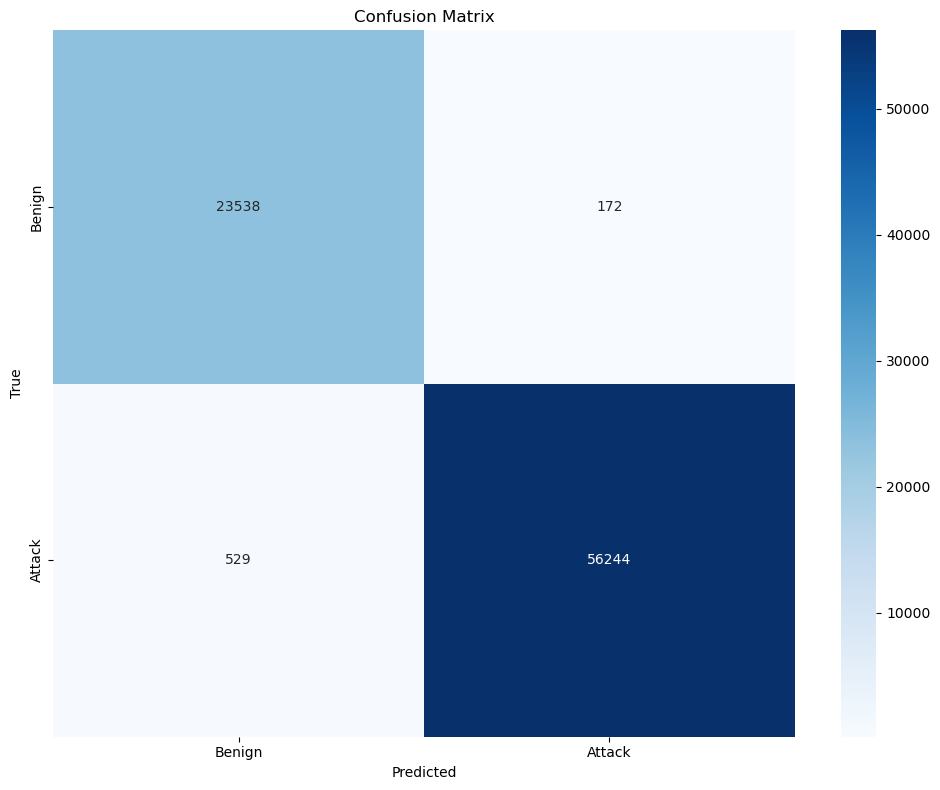

In [41]:


def plot_confusion_matrix(y_true, y_pred, class_names=None):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names if class_names else 'auto',
                yticklabels=class_names if class_names else 'auto')
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    
    plt.tight_layout()
    plt.show()

test_model.eval()

x = graph_data.x.to(device)
edge_index = graph_data.edge_index.to(device)
y = graph_data.y.to(device)

test_mask = graph_data.test_mask.to(device)

with torch.no_grad():
    out = test_model(x, edge_index)
    preds = out.argmax(dim=1) 

y_true = y[test_mask].cpu().numpy()
y_pred = preds[test_mask].cpu().numpy()

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="binary")  

print(f"Test Accuracy: {f"{accuracy*100:.2f}"}%")
print(f"Test F1-score: {f"{f1*100:.2f}"}%")


plot_confusion_matrix(y_true, y_pred, ['Benign', 'Attack'])


In [39]:
#torch.save(model.state_dict(), f"model_acc_{int(accuracy*10000)}_f1_{int(f1*100)}.pth")